<a href="https://colab.research.google.com/github/YoshifumiMiyagi/IP_LDL/blob/main/IP_LDL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import early_stopping

raw = pd.read_excel('/content/drive/MyDrive/R7_1_20_DB1_miyagi.xlsx')
print(raw.shape)
raw.head()

(72, 40)


,カルテ番号,Birth_date,Examin_date,Age_y,Age_m,Age_day,sex,Hight,Weight,HR,...,TimeStart_s_3,TimeEnd_s_3,BPStart_mmHg_3,BPEnd_mmHg_3,BPInterval_mmHg_3,Time_1,Time_2,Time_3,Time_12,Time_13
0,10617571,2005-01-26,2019-07-23,14,5,25.0,male,165.0,43.0,52,...,5.124352,5.274352,74.820000,84.220000,9.400000,1.135714,0.139286,0.150000,0.122642,0.107986
1,10617654,2005-01-26,2017-08-31,12,7,3.0,female,155.5,54.7,39,...,5.215946,5.332967,69.123457,75.172840,6.049383,1.638298,0.191489,0.117021,0.116883,0.071344
2,10634783,2004-11-23,2019-12-26,15,1,1.0,male,170.2,80.6,73,...,5.134950,5.195556,92.500000,116.500000,24.000000,0.868687,0.161616,0.060606,0.186047,0.214170
3,10644981,2003-11-15,2016-08-02,12,8,17.0,male,146.2,37.6,65,...,6.222073,6.294990,68.727273,75.272727,6.545455,0.989583,0.125000,0.072917,0.126316,0.127645
4,10676644,2006-08-08,2018-03-22,11,7,13.0,female,145.2,43.9,76,...,5.051939,5.153826,70.455882,89.117647,18.661765,0.826415,0.169811,0.101887,0.205479,0.248640


In [103]:
data = raw.iloc[:,3:]
data['sex'] = data['sex'].map({'male':1,'female':0})
data['Age_day'] = data['Age_day'].fillna(0)
data['LDL'] = data['LDL']
data = data.dropna(subset=['LDL'])

In [125]:
data2=data.copy()

RMV = ["sex"]
NUM_FEATURES = [c for c in data.columns if not c in RMV]

data2[NUM_FEATURES] = data2[NUM_FEATURES]
data3 = pd.concat([data2[NUM_FEATURES],data2["sex"]],axis=1)
data3.isnull().sum()

,0
Age_y,0
Age_m,0
Age_day,0
Hight,0
Weight,0
HR,0
sysBP,0
dysBP,0
aveBP,0
CAVI(R),0


In [253]:
from sklearn.feature_selection import mutual_info_regression
# Calculate mutual information
mutual_info = mutual_info_regression(data3.drop('LDL',axis=1), data['LDL'])

# Create a DataFrame to display results
mutual_info_df = pd.DataFrame({'Feature': data3.drop('LDL',axis=1).columns, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)
mutual_info_df[:5]

,Feature,Mutual Information
24,BPInterval_mmHg_2,0.185754
0,Age_y,0.132919
17,BPStart_mmHg_1,0.116372
21,TimeEnd_s_2,0.090052
10,ABI(R),0.057671


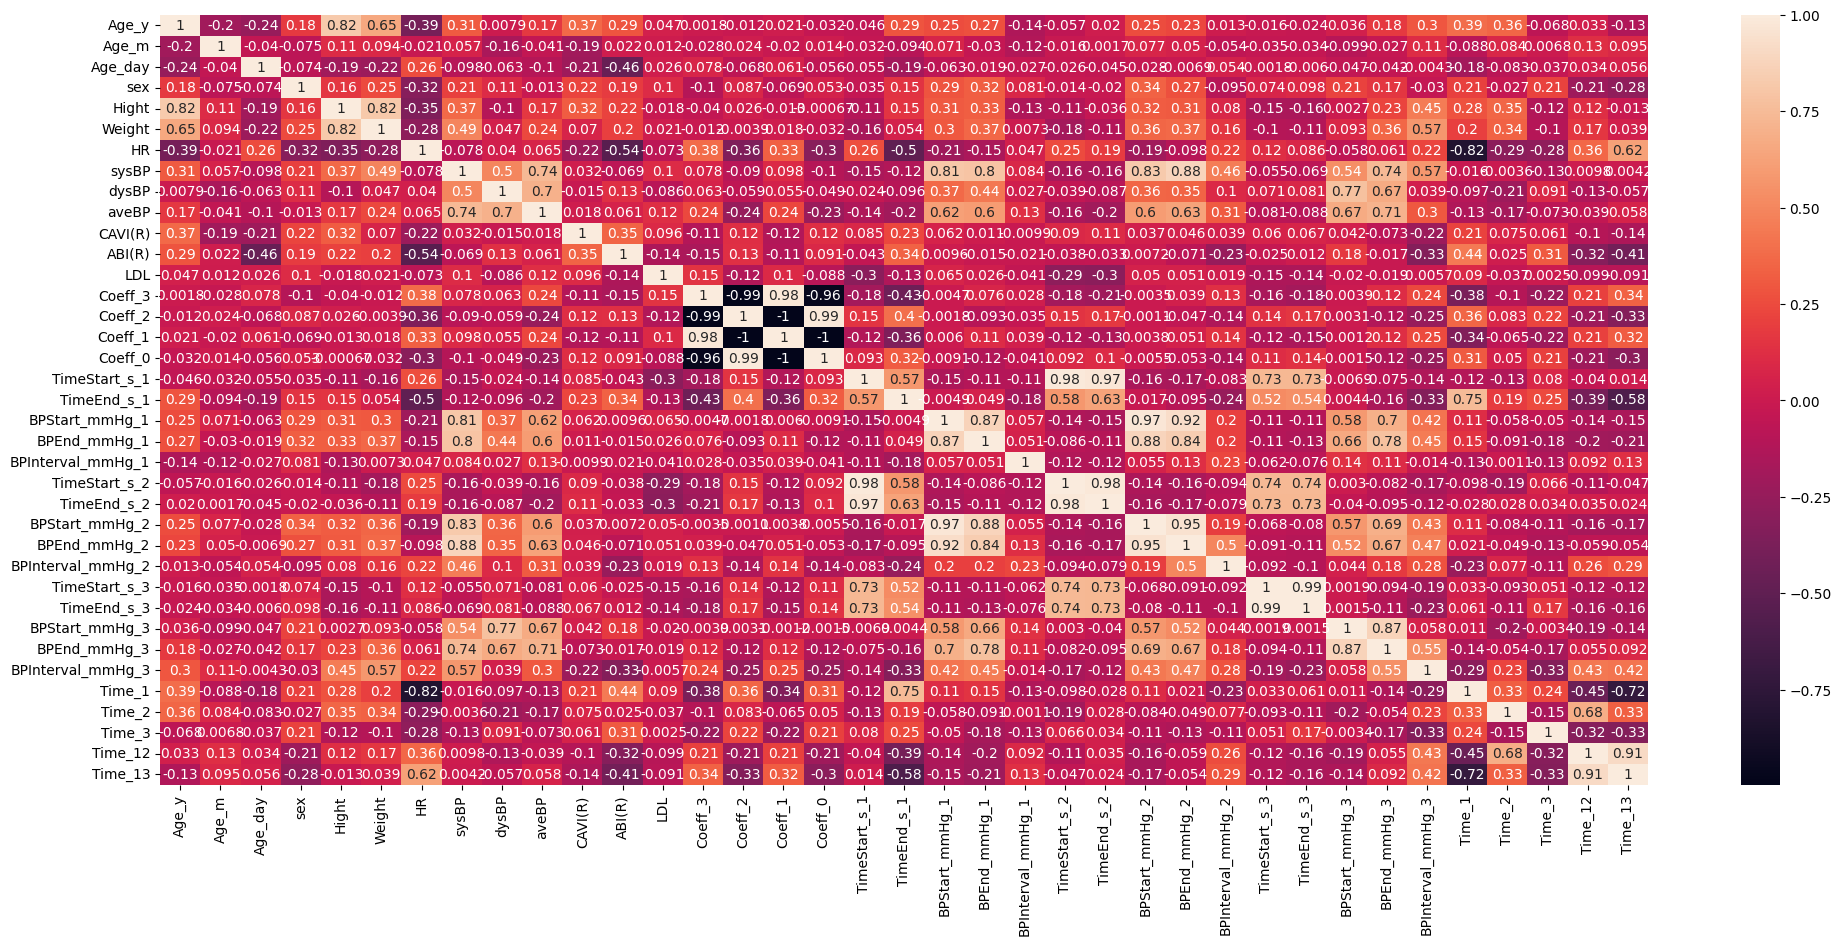

In [106]:
# prompt: dataのcorr　heatmap annot=T

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24, 10))
sns.heatmap(data.corr(), annot=True)
plt.show()


In [126]:
data3.corr()["LDL"].abs().sort_values(ascending=False)

,LDL
LDL,1.000000
TimeStart_s_1,0.299666
TimeEnd_s_2,0.298783
TimeStart_s_2,0.285740
TimeStart_s_3,0.146041
Coeff_3,0.145454
TimeEnd_s_3,0.143876
ABI(R),0.143580
TimeEnd_s_1,0.126806
Coeff_2,0.121267


In [127]:
feature =["TimeStart_s_1","Coeff_3",'aveBP',"LDL",'Coeff_2','sex','CAVI(R)','ABI(R)',"BPInterval_mmHg_2"]

In [128]:
# 相関係数を計算
correlation_with_ldl = data3[feature].corr()

# LDLとの相関係数を表示
correlation_with_ldl

,TimeStart_s_1,Coeff_3,aveBP,LDL,Coeff_2,sex,CAVI(R),ABI(R),BPInterval_mmHg_2
TimeStart_s_1,1.000000,-0.183461,-0.136629,-0.299666,0.149987,-0.035194,0.085305,-0.043127,-0.083346
Coeff_3,-0.183461,1.000000,0.243138,0.145454,-0.994063,-0.104797,-0.111800,-0.147629,0.126988
aveBP,-0.136629,0.243138,1.000000,0.120571,-0.240384,-0.012813,0.018310,0.061333,0.306642
LDL,-0.299666,0.145454,0.120571,1.000000,-0.121267,0.104016,0.096177,-0.143580,0.018994
Coeff_2,0.149987,-0.994063,-0.240384,-0.121267,1.000000,0.086538,0.118723,0.129241,-0.138148
sex,-0.035194,-0.104797,-0.012813,0.104016,0.086538,1.000000,0.220472,0.185834,-0.095263
CAVI(R),0.085305,-0.111800,0.018310,0.096177,0.118723,0.220472,1.000000,0.345074,0.039390
ABI(R),-0.043127,-0.147629,0.061333,-0.143580,0.129241,0.185834,0.345074,1.000000,-0.233723
BPInterval_mmHg_2,-0.083346,0.126988,0.306642,0.018994,-0.138148,-0.095263,0.039390,-0.233723,1.000000


In [129]:
data3[feature].describe()

,TimeStart_s_1,Coeff_3,aveBP,LDL,Coeff_2,sex,CAVI(R),ABI(R),BPInterval_mmHg_2
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,4.845904,0.000024,85.191176,165.347059,-0.024714,0.426471,4.772059,1.012353,11.218906
std,0.143642,0.000026,5.948178,49.919776,0.025692,0.498241,0.748699,0.074436,3.711754
min,4.475850,-0.000107,71.000000,92.000000,-0.097488,0.000000,3.400000,0.840000,4.888889
25%,4.784337,0.000014,81.000000,131.000000,-0.034027,0.000000,4.400000,0.940000,8.446154
50%,4.835814,0.000022,84.500000,150.500000,-0.023592,0.000000,4.700000,1.025000,10.884058
75%,4.871332,0.000033,89.000000,205.250000,-0.014519,1.000000,5.200000,1.060000,13.836349
max,5.451025,0.000098,97.000000,296.000000,0.111086,1.000000,7.100000,1.190000,19.500000


# Features creation

In [130]:
Train = data3[feature].copy()
Train.isnull().sum()

,0
TimeStart_s_1,0
Coeff_3,0
aveBP,0
LDL,0
Coeff_2,0
sex,0
CAVI(R),0
ABI(R),0
BPInterval_mmHg_2,0


In [131]:
!pip install featuretools

In [132]:
import featuretools as ft

In [133]:
es = ft.EntitySet()
es

Entityset: None
  DataFrames:
  Relationships:
    No relationships

In [134]:
es = es.add_dataframe(dataframe_name="example", dataframe=Train.drop('LDL',axis=1) ,index='level_0')
es

/usr/local/lib/python3.11/dist-packages/featuretools/entityset/entityset.py:1733: UserWarning: index level_0 not found in dataframe, creating new integer column
  warnings.warn(


Entityset: None
  DataFrames:
    example [Rows: 68, Columns: 9]
  Relationships:
    No relationships

In [135]:
es["example"].ww.schema

,Logical Type,Semantic Tag(s)
Column,,
level_0,Integer,['index']
TimeStart_s_1,Double,['numeric']
Coeff_3,Double,['numeric']
aveBP,Integer,['numeric']
Coeff_2,Double,['numeric']
sex,Integer,['numeric']
CAVI(R),Double,['numeric']
ABI(R),Double,['numeric']
BPInterval_mmHg_2,Double,['numeric']


In [136]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name='example',
                                      trans_primitives=['add_numeric', 'subtract_numeric'],
                                      agg_primitives=['count', 'sum', 'mean'],
                                      max_depth=1)
feature_matrix

/usr/local/lib/python3.11/dist-packages/featuretools/synthesis/dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['count', 'mean', 'sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


,TimeStart_s_1,Coeff_3,aveBP,Coeff_2,sex,CAVI(R),ABI(R),BPInterval_mmHg_2,ABI(R) + BPInterval_mmHg_2,ABI(R) + CAVI(R),...,Coeff_2 - sex,Coeff_3 - TimeStart_s_1,Coeff_3 - sex,aveBP - BPInterval_mmHg_2,aveBP - CAVI(R),aveBP - Coeff_2,aveBP - Coeff_3,aveBP - TimeStart_s_1,aveBP - sex,sex - TimeStart_s_1
level_0,,,,,,,,,,,,,,,,,,,,,
0,4.802924,0.000005,89,-0.005214,1,5.2,1.03,10.340000,11.370000,6.23,...,-1.005214,-4.802919,-0.999995,78.660000,83.8,89.005214,88.999995,84.197076,88.0,-3.802924
1,4.790414,0.000003,81,-0.004286,0,4.7,1.15,5.444444,6.594444,5.85,...,-0.004286,-4.790411,0.000003,75.555556,76.3,81.004286,80.999997,76.209586,81.0,-4.790414
2,4.771314,0.000031,97,-0.032226,1,4.5,1.07,19.500000,20.570000,5.57,...,-1.032226,-4.771283,-0.999969,77.500000,92.5,97.032226,96.999969,92.228686,96.0,-3.771314
3,4.878323,0.000028,84,-0.030933,1,5.4,1.04,7.636364,8.676364,6.44,...,-1.030933,-4.878295,-0.999972,76.363636,78.6,84.030933,83.999972,79.121677,83.0,-3.878323
4,4.723637,0.000033,81,-0.033842,0,4.7,1.02,6.911765,7.931765,5.72,...,-0.033842,-4.723604,0.000033,74.088235,76.3,81.033842,80.999967,76.276363,81.0,-4.723637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,4.816443,0.000010,84,-0.009801,0,5.2,1.04,10.800000,11.840000,6.24,...,-0.009801,-4.816433,0.000010,73.200000,78.8,84.009801,83.999990,79.183557,84.0,-4.816443
64,5.194707,0.000042,83,-0.040964,0,4.6,0.90,9.743590,10.643590,5.50,...,-0.040964,-5.194665,0.000042,73.256410,78.4,83.040964,82.999958,77.805293,83.0,-5.194707
65,4.832386,0.000018,91,-0.021217,0,4.6,1.06,8.833333,9.893333,5.66,...,-0.021217,-4.832368,0.000018,82.166667,86.4,91.021217,90.999982,86.167614,91.0,-4.832386


In [141]:
Train_ft = feature_matrix
Train_ft.isnull().sum()

,0
TimeStart_s_1,0
Coeff_3,0
aveBP,0
Coeff_2,0
sex,0
...,...
sex_*_TimeStart_s_1_/_aveBP,0
sex_*_Coeff_3_*_aveBP,0
sex_*_Coeff_2_*_aveBP,0
sex_*_TimeStart_s_1_*_CAVI(R),0


In [138]:
def numeric_fe(df):
    df['TimeStart_s_1_*_Coeff_3'] = df['TimeStart_s_1'] *np.log1p(df['Coeff_3'])
    df['TimeStart_s_1_*_aveBP'] = df['TimeStart_s_1'] * df['aveBP']
    df['Coeff_3_/_TimeStart_s_1_'] = np.log1p(df['Coeff_3']) / df['TimeStart_s_1']
    df['Coeff_3_/_aveBP'] = np.log1p(df['Coeff_3']) / df['aveBP']

    df['Coeff_2_/_TimeStart_s_1_'] = np.log1p(df['Coeff_2']) / df['TimeStart_s_1']
    df['Coeff_2_/_aveBP'] = np.log1p(df['Coeff_2']) / df['aveBP']
    df['Coeff_2_*_aveBP'] = np.log1p(df['Coeff_2']) * df['aveBP']
    df['Coeff_2_*_TimeStart_s_1'] = np.log1p(df['Coeff_2']) * df['TimeStart_s_1']
    df['Coeff_2_*_aveBP'] = np.log1p(df['Coeff_2']) * df['aveBP']

    df['TimeStart_s_1_*_CAVI(R)'] = df['TimeStart_s_1'] * df['CAVI(R)']
    df['TimeStart_s_1_*_ABI(R)'] = df['TimeStart_s_1'] * df['ABI(R)']

    df['TimeStart_s_1_/_aveBP'] = df['TimeStart_s_1'] / df['aveBP']
    df['Coeff_3_*_aveBP'] = np.log1p(df['Coeff_3']) * df['aveBP']
    df['Coeff_2_*_aveBP'] = np.log1p(df['Coeff_2']) * df['aveBP']

    df['sex_*_TimeStart_s_1'] = df['sex'] * df['TimeStart_s_1']
    df['sex_*_Coeff_3'] = df['sex'] * np.log1p(df['Coeff_3'])
    df['sex_*_aveBP'] = df['sex'] * df['aveBP']
    df['sex_*_CAVI(R)'] = df['sex'] * df['CAVI(R)']
    df['sex_*_ABI(R)'] = df['sex'] * df['ABI(R)']
    df['sex_*_Coeff_2'] = df['sex'] * np.log1p(df['Coeff_2'])
    df['sex_*_TimeStart_s_1_/_aveBP'] = df['sex'] * df['TimeStart_s_1'] / df['aveBP']
    df['sex_*_Coeff_3_*_aveBP'] = df['sex'] * np.log1p(df['Coeff_3']) * df['aveBP']
    df['sex_*_Coeff_2_*_aveBP'] = df['sex'] * np.log1p(df['Coeff_2']) * df['aveBP']
    df['sex_*_TimeStart_s_1_*_CAVI(R)'] = df['sex'] * df['TimeStart_s_1'] * df['CAVI(R)']
    df['sex_*_TimeStart_s_1_*_ABI(R)'] = df['sex'] * df['TimeStart_s_1'] * df['ABI(R)']
    df['sex_*_TimeStart_s_1_/_aveBP'] = df['sex'] * df['TimeStart_s_1'] / df['aveBP']

    return df

In [142]:
dat = numeric_fe(Train_ft)
dat.isnull().sum()

,0
TimeStart_s_1,0
Coeff_3,0
aveBP,0
Coeff_2,0
sex,0
...,...
sex_*_TimeStart_s_1_/_aveBP,0
sex_*_Coeff_3_*_aveBP,0
sex_*_Coeff_2_*_aveBP,0
sex_*_TimeStart_s_1_*_CAVI(R),0


In [147]:
data3['LDL'].reset_index(drop=True, inplace=True)
dat['LDL'] = data3['LDL']
dat

,TimeStart_s_1,Coeff_3,aveBP,Coeff_2,sex,CAVI(R),ABI(R),BPInterval_mmHg_2,ABI(R) + BPInterval_mmHg_2,ABI(R) + CAVI(R),...,sex_*_aveBP,sex_*_CAVI(R),sex_*_ABI(R),sex_*_Coeff_2,sex_*_TimeStart_s_1_/_aveBP,sex_*_Coeff_3_*_aveBP,sex_*_Coeff_2_*_aveBP,sex_*_TimeStart_s_1_*_CAVI(R),sex_*_TimeStart_s_1_*_ABI(R),LDL
level_0,,,,,,,,,,,,,,,,,,,,,
0,4.802924,0.000005,89,-0.005214,1,5.2,1.03,10.340000,11.370000,6.23,...,89,5.2,1.03,-0.005228,0.053965,0.000429,-0.465252,24.975204,4.947012,107.0
1,4.790414,0.000003,81,-0.004286,0,4.7,1.15,5.444444,6.594444,5.85,...,0,0.0,0.00,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,193.0
2,4.771314,0.000031,97,-0.032226,1,4.5,1.07,19.500000,20.570000,5.57,...,97,4.5,1.07,-0.032756,0.049189,0.002981,-3.177365,21.470911,5.105305,108.0
3,4.878323,0.000028,84,-0.030933,1,5.4,1.04,7.636364,8.676364,6.44,...,84,5.4,1.04,-0.031421,0.058075,0.002383,-2.639378,26.342944,5.073456,252.0
4,4.723637,0.000033,81,-0.033842,0,4.7,1.02,6.911765,7.931765,5.72,...,0,0.0,0.00,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,4.816443,0.000010,84,-0.009801,0,5.2,1.04,10.800000,11.840000,6.24,...,0,0.0,0.00,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,137.0
64,5.194707,0.000042,83,-0.040964,0,4.6,0.90,9.743590,10.643590,5.50,...,0,0.0,0.00,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,125.0
65,4.832386,0.000018,91,-0.021217,0,4.6,1.06,8.833333,9.893333,5.66,...,0,0.0,0.00,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,154.0


In [256]:
from sklearn.feature_selection import mutual_info_regression
# Calculate mutual information
mutual_info = mutual_info_regression(dat.drop('LDL',axis=1), dat['LDL'])

# Create a DataFrame to display results
mutual_info_df = pd.DataFrame({'Feature': dat.drop('LDL',axis=1).columns, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)
mutual_info_df[:5]

,Feature,Mutual Information
18,BPInterval_mmHg_2 + TimeStart_s_1,0.243625
16,BPInterval_mmHg_2 + Coeff_2,0.200657
36,ABI(R) - BPInterval_mmHg_2,0.197405
7,BPInterval_mmHg_2,0.185979
45,BPInterval_mmHg_2 - Coeff_3,0.185979


In [148]:
dat.corr()['LDL'].sort_values(ascending=False)[:10]

,LDL
LDL,1.000000
Coeff_3 - TimeStart_s_1,0.299682
Coeff_2 - TimeStart_s_1,0.281036
ABI(R) - TimeStart_s_1,0.196570
sex - TimeStart_s_1,0.181267
Coeff_3_/_TimeStart_s_1_,0.159341
CAVI(R) - TimeStart_s_1,0.153358
Coeff_3_*_aveBP,0.152899
Coeff_3,0.145454
Coeff_3_/_aveBP,0.136609


In [342]:
LIST = dat.corr()['LDL'].sort_values(ascending=False)[:2].index.tolist()
LIST = ['TimeStart_s_1','TimeStart_s_1_*_ABI(R)','TimeStart_s_1_/_aveBP','BPInterval_mmHg_2 + TimeStart_s_1','LDL']
#LIST = ['Coeff_3 - TimeStart_s_1','LDL']
LIST

['TimeStart_s_1',
 'TimeStart_s_1_*_ABI(R)',
 'TimeStart_s_1_/_aveBP',
 'BPInterval_mmHg_2 + TimeStart_s_1',
 'LDL']

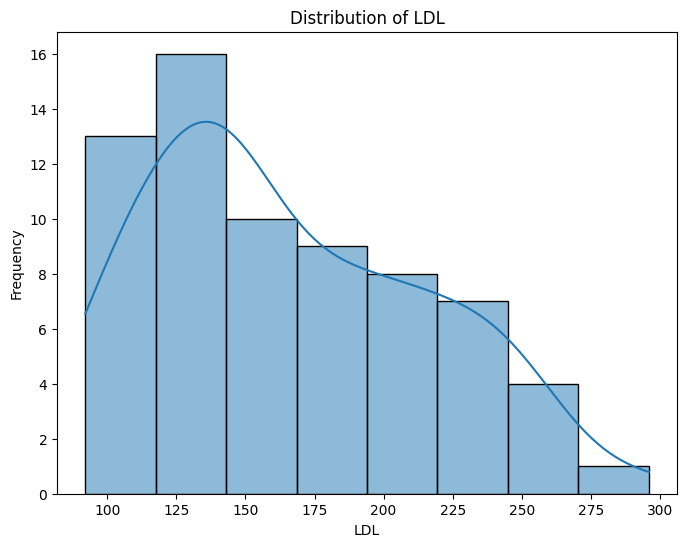

In [343]:
# prompt: LDLの分布をplot

import matplotlib.pyplot as plt
import seaborn as sns

# LDLの分布をヒストグラムで表示
plt.figure(figsize=(8, 6))
sns.histplot(data['LDL'], kde=True)  # kde=Trueでカーネル密度推定を表示
plt.title('Distribution of LDL')
plt.xlabel('LDL')
plt.ylabel('Frequency')
plt.show()

In [344]:
Dat = dat[LIST]
Dat

,TimeStart_s_1,TimeStart_s_1_*_ABI(R),TimeStart_s_1_/_aveBP,BPInterval_mmHg_2 + TimeStart_s_1,LDL
level_0,,,,,
0,4.802924,4.947012,0.053965,15.142924,107.0
1,4.790414,5.508976,0.059141,10.234859,193.0
2,4.771314,5.105305,0.049189,24.271314,108.0
3,4.878323,5.073456,0.058075,12.514687,252.0
4,4.723637,4.818110,0.058317,11.635402,111.0
...,...,...,...,...,...
63,4.816443,5.009101,0.057339,15.616443,137.0
64,5.194707,4.675236,0.062587,14.938296,125.0
65,4.832386,5.122329,0.053103,13.665719,154.0


In [345]:
Dat.isnull().sum()

,0
TimeStart_s_1,0
TimeStart_s_1_*_ABI(R),0
TimeStart_s_1_/_aveBP,0
BPInterval_mmHg_2 + TimeStart_s_1,0
LDL,0


In [428]:
X, y = Dat.drop('LDL',axis=1), dat['LDL']/dat['BPInterval_mmHg_2 + TimeStart_s_1']

In [429]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [430]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# # 正規化 (Min-Max スケーリング)
scaler_minmax = MinMaxScaler()
X_train_ = scaler_minmax.fit_transform(X_train)
X_test_ = scaler_minmax.transform(X_test)

# # 標準化 (Z-score 標準化)
# scaler_standard = StandardScaler()
# X_train = scaler_standard.fit_transform(X_train)
# X_test = scaler_standard.transform(X_test)


In [431]:
# prompt: 線形回帰

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Print coefficients and intercept
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

Mean Squared Error: 13.711921251899065
R-squared: 0.516300105508444
Coefficients: [ -3.13237997  -1.072481   -81.53264084  -0.77664528]
Intercept: 48.32687018125454


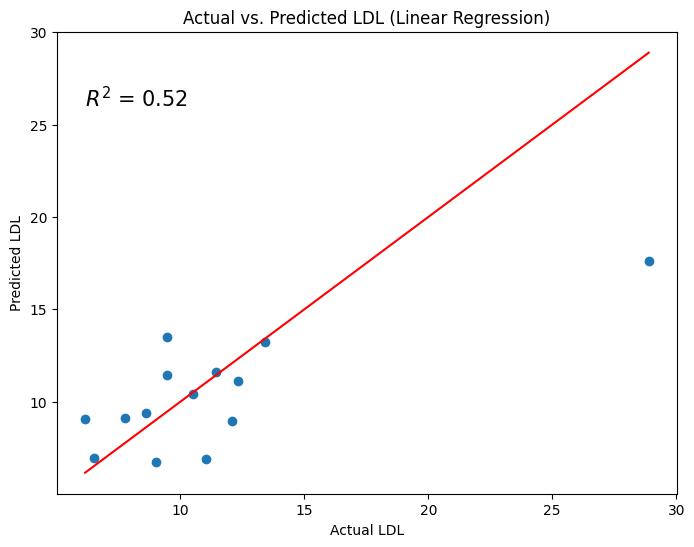

In [432]:
# prompt: 予測の線形回帰のプロット

# Plot the predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Add a diagonal line for reference
plt.xlabel("Actual LDL")
plt.ylabel("Predicted LDL")
plt.text(min(y_test), max(y_test) * 0.9,f'$R^2$ = {r2:.2f}', fontsize=15)
plt.title("Actual vs. Predicted LDL (Linear Regression)")
plt.show()

In [433]:
# prompt: 決定木で

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 決定木モデルの作成と学習
model = DecisionTreeRegressor(random_state=42, max_depth=2)  # random_state を設定
model.fit(X_train, y_train)

# テストデータでの予測
y_pred = model.predict(X_test)

# モデルの評価
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 18.02769164382526
R^2 Score: 0.36405756816632173


In [453]:

import xgboost as xgb

# Create XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=9,max_depth=3,reg_lambda=0.1,eta=0.31) # Use appropriate objective function

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Mean Squared Error: {mse}")
print(f"XGBoost R-squared: {r2}")

XGBoost Mean Squared Error: 11.096166091663056
XGBoost R-squared: 0.6085731336113926


In [454]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

MSE: 11.096166091663056, RMSE: 3.331090826090315, MAE: 2.687915673773613, R^2: 0.6085731336113926


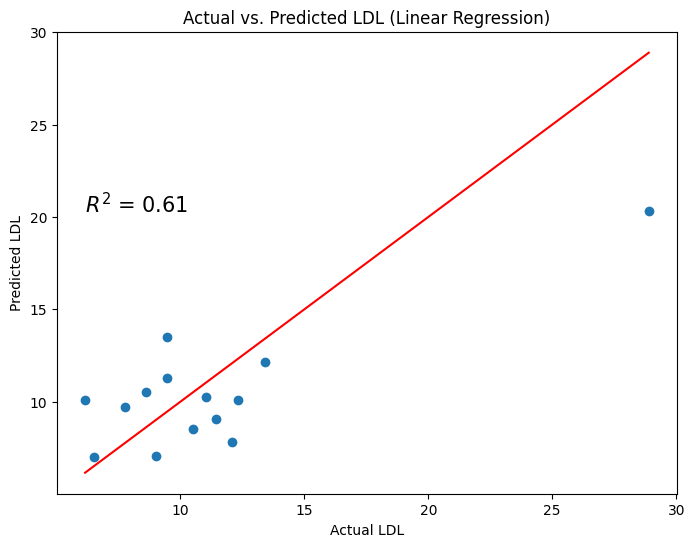

In [455]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Add a diagonal line for reference
plt.xlabel("Actual LDL")
plt.ylabel("Predicted LDL")
plt.text(min(y_test), max(y_test) * 0.7,f'$R^2$ = {r2:.2f}', fontsize=15)
plt.title("Actual vs. Predicted LDL (Linear Regression)")
plt.show()